## TvsP_ABM_02 - Regulation at the source? Comparing upstream and downstream climate policies

*An agent-based model to evaluate and compare the performance of upstream and downstream climate policies.*

Joël Foramitti, Ivan Savin, Jeroen C.J.M. van den Bergh

***

**Content**
1. Initialization
2. Settings & Parameters
3. Agents 
4. Markets
5. Main Dynamics
6. Model Analysis
    1. Multiple Runs
    2. Single Run

### 1. Initialization

In [64]:
## Libraries ##

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import copy
import csv

from operator import itemgetter
from tabulate import tabulate
from datetime import date

from SALib.sample import saltelli
from SALib.analyze import sobol

### 2. Settings & Parameters

In [65]:
# Simulation Settings

scenarios = ["No_Policy","Downtax","Downmarket","Direct_Regulation","Uptax","Upmarket"] # Which scenarios should be compared?

analyze_single_run = True # Show main dynamics for a single run
single_run_details = False # Show time-series for every variable
single_run_mode = "mid-point" # How to select from param_range: mid-point, upper-bound, lower-bound, random, id
glob_id = 1055 # Used if single_run_mode == id
fixed_seed = True # Use fixed seed for random values?
glob_seed = 13 # Seed for random parameters

do_multi_run = False # Run over variation of paramters
analyze_multi_run = False # Show evaluation criteria plot
analyze_sensitivity = False # Show sensitivity analysis plot
sensitivity_strength = 10000 # Number of runs: num_vars * 2 + 2
plot_sensitivity = False 

# Seperate simulation into smaller batches
batch_seperation = False
batch_total = 10
batch_current = 0 # start counting from 0!
batch_combination = False

print_errors = True # Display error messages?
fs = 13 # Font size for plots

In [66]:
# Show Chosen ID Parameters
# print(saltelli.sample(param_range, sensitivity_strength)[1055])
# len(saltelli.sample(param_range, sensitivity_strength))

In [67]:
## 000 Parameters

if fixed_seed == True: np.random.seed(glob_seed) 

param_range = {
    'num_vars': 12,
    'names': ['$λ$','$ρ_s/ρ_m$', '$Δθ$','$ΔA_0$,$ΔB_0$', 'Δμ', 'Δη','Δρ','θ','σ','ϑ','χ','μ'],
    'bounds': [[0.1  , 0.7 ], #1  - λ - Abatement potential
               [  1  , 20  ], #2  - ρ_s/ρ_m - q_step_costs_up_diff
               [0.1  , 0.5 ], #3  - Δθ - Abatement Cost Heterogeneity
               [0.1  , 0.5 ], #4  - ΔA_0,ΔB_0 - Heterogeneity of production factors
               [0.1  , 0.5 ], #5  - Δμ - price adaption trading
               [0.1  , 0.5 ], #6  - Δη - Heterogeneity of profitability target  
               [0.1  , 0.5 ], #7  - Δρ - Heregoeneity of expansion step costs
               [1    , 20  ], #8  - θ - Abatement cost factor
               [0.1  , 0.2 ], #9  - σ - Scarcity mark-up adaption rate      
               [0.1  , 0.2 ], #10 - ϑ - Dosi Mark-up adaptation rate
               [0.1  , 0.2 ], #11 - χ - Market share adaptation rate
               [0.1  , 0.2 ]] #12 - μ - Price adaption rate        
}    

class c_parameters:
    def __init__(self,variable_parameters):    
        
        # Fixed parameters
        self.T = 200 # Number of rounds
        self.Np = self.Np_c = 30 # Number of final goods producers
        self.Nf = self.Nf_c = 10 # Number of fossil fuel suppliers
        self.t_init = 50 # Number of rounds for initialization
        self.t_start= 50 # Delay until policy starts
        self.t_impl = 100 # Number of implementation periods         
        self.D0 = 1 # Maximum demand
        self.A00 = 1 # Fuel and Emission intensity 
        self.B00 = self.B00_up = 1 # Production costs 
        self.qI_d = 1 # Desired inventory 
        self.ω = [1,1] # Market-share evolution weights          
        self.λ_n = 20 # Number of technological steps    
        self.α0 = 15 # Abatement cost ground level 
        self.γ = 0.1 # Demand sensitivity
        self.E_max = 0.1 # Emission Target
        self.m0 = 0.1 # Dosi mark-up rate in the beginning          
        self.eta = 0.1 # Profitability target   
        self.pe0 = 0.1 # Initial trading price for fuel and permits 
        self.q_step = self.q_step_up = 0.01 # Expansion step
        self.q_step_cost = 0.001 # Costs of each expansion step
        self.q_depr = 0.95 # Capital depreciation rate 
        self.η_c = 0.15 # Coverage Factor
        self.q_max_0 = 0.1 # Initial production capacity
        self.qf_d_min = 0.0001 # Minimum fuel order 
        
        # Calibration parameters
        self.calibration_treshold = 10**(-2)
        self.calibration_max_runs = 20 
        self.tax = 100 # Upper bound for tax
        self.dr0 = 0.5 # Upper bound for direct regulation
        
        # Variable parameters
        self.λ_max, self.q_step_cost_up_diff, self.Δα, self.ΔAB, self.Δδ, self.Δeta, self.Δq_step_cost, self.α, self.δm2,self.ϑ,self.χ,self.δ  = variable_parameters
        self.q_step_cost_up = self.q_step_cost * self.q_step_cost_up_diff
        self.δ_up = self.δ 
        
        # Toggle model dynamics
        self.calibrate = True   

        # Error log
        self.error = False
        self.log = []

    def generate_random_par(self):
               
        a = [self.δ * ( 1 + self.Δδ * ( np.random.random() - 0.5 ) ) for i in range(self.Np)]
        b = [self.A00 * ( 1 + self.ΔAB * ( np.random.random() - 0.5 ) ) for i in range(self.Np)]
        c = [self.B00 * ( 1 + self.ΔAB * ( np.random.random() - 0.5 ) ) for i in range(self.Np)]
        d = [self.α * ( 1 + self.Δα * ( np.random.random() - 0.5 ) ) for i in range(self.Np)]
        e = [self.B00_up * ( 1 + self.ΔAB * ( np.random.random() - 0.5 ) ) for i in range(self.Nf)]
        f = [self.q_step_cost_up * ( 1 + self.Δq_step_cost * ( np.random.random() - 0.5 ) ) for i in range(self.Nf)] 
        g = [self.δ_up * ( 1 + self.Δδ * ( np.random.random() - 0.5 ) ) for i in range(self.Nf)]
        h = [self.q_step_cost * ( 1 + self.Δq_step_cost * ( np.random.random() - 0.5 ) ) for i in range(self.Np)] 
        i = [self.eta * ( 1 + self.Δeta * ( np.random.random() - 0.5 ) ) for i in range(self.Np)] 
    
        return [a,b,c,d,e,f,g,h,i]
    
    def load_random_par(self,random_par):
        
        self.δ,self.A0,self.B0,self.α,self.B0_up,self.q_step_cost_up,self.δ_up,self.q_step_cost, self.eta = random_par  
        
        self.λ = [] # Abatement List
        for i in range(self.Np): self.λ.append( self.generate_λ(self.α[i],self.A0[i]) )
        
    # Abatement cost curve
    def generate_λ(self,α,A0):     
        λ =[] 
        for i in range(self.λ_n):
            a=(A0*self.λ_max)/self.λ_n     
            MAC=a*α*(i+1) + self.α0 
            b=a*MAC
            λ.append([a,b])
            
        return λ       
        
    # Manage errors
    def report_error(self,statement):
        self.error = True
        if statement not in self.log:
            self.log.append(statement) 
            
    # Calculate number of firms covered
    def coverage(self):
        if self.regpoint == "upstream": self.Nf_c = int(round(self.Nf * (1 - self.η_c)))
        elif self.regpoint == "downstream": self.Np_c = int(round(self.Np * (1 - self.η_c)))            
            
    # Scenarios 
    def load_sc(self,scenario):
        # Load Scenario
        getattr(self,scenario)() 
        
    def No_Policy(self):
        self.mode = "No Policy"
        self.label = "No Policy"
        self.regpoint = "None"
    
    def Direct_Regulation(self):
        self.mode = "Direct_Regulation"
        self.label = "Upstream Direct Regulation" 
        self.regpoint = "upstream" 
        
    def Upmarket(self):
        self.mode = "Permits"
        self.label = "Upstream permit market"
        self.regpoint = "upstream"
        
    def Downmarket(self):
        self.mode = "Permits"
        self.label = "Downstream permit market"
        self.regpoint = "downstream"
        
    def Uptax(self):
        self.mode = "Tax"
        self.label = "Upstream tax"
        self.regpoint = "upstream"
        
    def Downtax(self):
        self.mode = "Tax"
        self.label = "Downstream tax"
        self.regpoint = "downstream"
          

### 3. Agents

In [68]:
# Regulator

class c_regulator:  
    
    def __init__(self,p):
        self.qp, self.pe, self.px, self.pf, self.R = np.zeros((5,p.T+1)) 
        self.permit_market = False
        self.emission_tax = False
        self.x = 0 
   
    def update_policy(self,economy,p,t):  
        
        if t >= p.t_start: 
            self.x = min( t - p.t_start + 1 , p.t_impl ) # Step of gradual implementation 
            if p.mode == "Tax":
                self.emission_tax = True
                self.set_tax(economy,p,t)     
            if p.mode == "Permits": 
                self.permit_market = True
                self.set_permits(economy,p,t)
            if p.mode == "Direct_Regulation":
                self.set_direct_regulation(economy,p,t)
                
    def set_permits(self,economy,p,t): 
   
        u_sec, d_sec = economy
        self.qp[t] += ( p.d_sec.E[p.t_start-1] - ( p.d_sec.E[p.t_start-1] - p.E_max ) * self.x / p.t_impl )        

    def set_tax(self,economy,p,t): 
        
        u_sec, d_sec = economy
        
        if p.regpoint == "upstream":
            
            self.pe[t] = p.tax * self.x / p.t_impl 
            for j in u_sec: 
                if j.covered == True:
                    j.pe[t] = self.pe[t]
                
        elif p.regpoint == "downstream":
            
            self.pe[t] = p.tax * self.x / p.t_impl 
            for j in d_sec: 
                if j.covered == True:
                    j.pe[t] = self.pe[t] 
                
    def set_direct_regulation(self,economy,p,t):
        
        u_sec, d_sec = economy
        
        if p.d_sec.E[t-1] > p.E_max:
            for j in u_sec: j.expansion = "blocked"
        else:
            for j in u_sec: j.expansion = "limited" 
                
        
# Economy

class c_economy(list):
    
    def apply(self,method,p,t):
        # Run method in each list element
        for obj in self: obj.apply(method,p,t)      
       
    
# Sector

class c_sector(list):
     
    def __init__(self,p,pos,N,N_c):
        
        super().__init__()
        self.N = N
        self.D, self.E, self.Q, self.u_t, self.p, self.Dlr = np.zeros((6,p.T+1)) 
        
        if pos == "upstream": 
            for j in range(N): 
                if j <= N_c: self.append(c_upfirm(p,j,N,self)) # Check if covered
                else: self.append(c_upfirm(p,j,N,self,covered=False))
        elif pos == "downstream":
            for j in range(N): 
                if j <= N_c: self.append(c_downfirm(p,j,N,self)) # Check if covered
                else: self.append(c_downfirm(p,j,N,self,covered=False))
            
    def production(self,p,t):
        
        self.apply("production",p,t)
        
        # Total emissions
        self.E[t] = sum([j.e[t] for j in self])

        # Production shares
        self.Q[t] = sum([j.qg[t] for j in self])
        for j in self:
            if self.Q[t] > 0: j.sq[t] = j.qg[t]/self.Q[t]
            else: j.sq[t] = 1/self.N
        
    def apply(self, method,p,t):
        
        # Run method in each list element
        for obj in self:
            getattr(obj, method)(p,t)         


# Firm         
              
class c_firm:
    
    def __init__(self,p,j,N,sec,covered=True):
        
        # Parameters
        self.j = j # Firm Index Number
        self.sec = sec # Firm sector
        self.α = p.α[j] # Abatement cost factor
        self.δ = p.δ[j] # Permit price adaption rate
        self.η = p.eta[j] # Profitability target
        self.λ = copy.deepcopy(p.λ[j]) # List of abatement options [[a,b],[a,b],...]
        self.λ0 = copy.deepcopy(p.λ[j]) # Copy of list for documentation
        self.qI_d = p.qI_d # Desired inventory 
        self.δm2 = p.δm2 # Scarcity mark-up adaption rate
        self.expansion = "allowed" # Expansion allowed?
        self.covered = covered # Affected by policy?
        
        # Dynamic variables
        self.s, self.sq, self.f, self.D, self.Dl = np.zeros((5,p.T+1)) # Market-Share & Demand
        self.qg, self.qg_s, self.qg_d, self.qg_i, self.q_max = np.zeros((5,p.T+1)) # Production
        self.pg, self.m, self.m2, self.A, self.B, self.C, self.π = np.zeros((7,p.T+1)) # Prices & Costs
        self.e, self.pe, self.qp_d, self.u_i, self.u_t, self.cu_t, self.MAC = np.zeros((7,p.T+1)) # Emission & Extraction 
        self.qf_d,self.pf,self.f_i,self.f_t,self.cf_t = np.zeros((5,p.T+1)) # Fuels
        
        # Initial values
        self.s[0] = 1 / N # Market Share
        self.m[0] = p.m0 # Mark-up rate
        self.q_max[0] = self.q_max[1] = p.q_max_0 
    
    def set_goal(self,p,t):
        
        # Update prices & inventories
        self.pf[t] = self.pf[t-1]
        self.f_i[t] = self.f_i[t-1] 
        self.qg_i[t] = self.qg_i[t-1]
        self.u_i[t] = self.u_i[t-1]
        
        # Set production goal
        self.qg_d[t] = max( 0 , self.D[t-1] * (1 + self.qI_d) - self.qg_i[t] ) 
            
    def set_mark_up(self,p,t): 
        
        # Set dosi mark-up rate            
        if t != 1 and self.s[t-2] > 0.01: self.m[t] = self.m[t-1] * ( 1 +  p.ϑ * ( self.s[t-1] - self.s[t-2] ) / self.s[t-2] ) 
        else: self.m[t] = self.m[t-1] 
        
        # Set scarcity mark-up rate
        if t != 1:
            if self.qg[t-1] < self.qg_d[t-1]:
                self.m2[t] = self.m2[t-1] + self.δm2
            else:
                self.m2[t] = max( 0 , self.m2[t-1] - self.δm2 )

    def order_permits(self,p,t):
        
        if self.pos == "upstream": self.qp_d[t] = qp_d = self.qg_d[t] * (1+self.qI_d) - self.u_i[t]
        else: self.qp_d[t] = qp_d = self.qg_d[t] * self.A[t] * (1+self.qI_d) - self.u_i[t]
        
        if qp_d != 0 and self.covered == True:
            order=[self.pe[t], qp_d ,self]
            p.p_ex.orders.append(order) 

    def expand(self,p,t):
        
        self.q_max[t+1] = self.q_max[t] * p.q_depr # Depreciation of production capacity
        
        self.A[t+1] = self.A[t] 
        self.B[t+1] = self.B[t] 

        # Investment into new production capacity
        if self.m2[t] * self.B[t] > self.q_step_cost / self.q_step * ( 1 + self.η ) and self.q_max[t] < self.qg_d[t]: 
            
            if self.expansion == "allowed" or self.covered == False:
                self.q_max[t+1] += self.q_step 
                self.B[t+1] += self.q_step_cost
            elif self.expansion == "limited":
                self.q_max[t+1] = self.q_max[t] * (1+p.dr0) 
                self.B[t+1] += self.q_step_cost / self.q_step * self.q_max[t] * (p.dr0)  
            
class c_upfirm(c_firm):

    def __init__(self,p,j,N,sec,covered=True):

        super().__init__(p,j,N,sec,covered)
        self.pos = "upstream"
        self.B[0] = self.B[1] = p.B0_up[j] # Production costs
        self.q_step_cost = p.q_step_cost_up[j] # Production cost increase from expansion
        self.q_step = p.q_step_up # Expansion step
        if p.mode == "Permits" and p.regpoint == self.pos and self.covered == True: self.pe[p.t_start] = p.pe0 # Permit trading price    
            
    def production(self,p,t):           
        
        self.qg[t] = min( self.qg_d[t] , self.q_max[t] ) 
        
        if p.reg.permit_market == True and p.regpoint == self.pos and self.covered == True: 
            self.qg[t] = min( self.qg[t] , self.u_i[t] ) 
        
        self.qg_i[t] += self.qg[t] # Add production to fuel inventory
        
        if p.reg.emission_tax == True and p.regpoint == self.pos and self.covered == True: p.reg.R[t] += self.qg[t] * self.pe[t]
        if p.reg.permit_market == True and p.regpoint == self.pos and self.covered == True: self.u_i[t] = self.u_i[t+1] = self.u_i[t] - self.qg[t] 
        
    def set_price(self,p,t):
        
        self.pg[t] = max( 0 , ( self.B[t] ) * ( 1 + self.m[t] + self.m2[t] ) + self.pe[t] )
            
    def order_fuel(self,p,t):
        
        order=[self.pg[t],min(0,-self.qg_i[t]),self]
        if self.qg_i[t] >= 0.01: p.f_ex.orders.append(order)
            

class c_downfirm(c_firm):
    
    def __init__(self,p,j,N,sec,covered=True):

        super().__init__(p,j,N,sec,covered)
        self.pos = "downstream"
        self.A[0] = self.A[1] = p.A0[j] # Emission intensity
        self.B[0] = self.B[1] = p.B0[j] # Production costs
        self.pf[0] = p.B00 # Initial fuel trading price   
        self.q_step_cost = p.q_step_cost[j] # Production cost increase from expansion
        self.q_step = p.q_step # Expansion step
        self.c_ab = 0 # Abatement costs
        if p.mode == "Permits" and p.regpoint == self.pos and self.covered == True: self.pe[p.t_start] = p.pe0 # Permit trading price
               
    def order_fuel(self,p,t):
        
        self.qf_d[t] = qf_d = ( self.qg_d[t] * self.A[t] ) * ( 1 + self.qI_d ) - self.f_i[t] 
        if qf_d >= p.qf_d_min:          
            order=[self.pf[t],qf_d,self]
            p.f_ex.orders.append(order)
            
    def production(self,p,t):
        
        # Production restricted by fuel stock 
        f_limitation = self.f_i[t] /  self.A[t] 
        self.qg[t] = min( self.qg_d[t] , f_limitation , self.q_max[t] ) 
        
        # Production restricted by permit market
        if p.reg.permit_market == True and p.regpoint == self.pos and self.covered == True: 
            if self.A[t] > 0: #* tl(p,t)
                self.qg[t] = min( self.qg[t] , self.u_i[t] / ( self.A[t] ) ) 
            else: p.report_error("Error in production(): self.A[t] * tl(p,t) <= 0")
        
        self.qg_i[t] += self.qg[t] # Add production to goods inventory
            
        # Fuel use and Emissions  
        self.e[t] = self.qg[t] * self.A[t] # Emissions
        self.f_i[t] -= self.qg[t] * self.A[t] # Fuel use
        
        # Tax collection and permit submission
        if p.reg.emission_tax == True and p.regpoint == self.pos and self.covered == True: p.reg.R[t] += self.e[t] * self.pe[t] 
        if p.reg.permit_market == True and p.regpoint == self.pos and self.covered == True: self.u_i[t] = self.u_i[t+1] = self.u_i[t] - self.e[t]  
            
    def set_price(self,p,t):
        
        self.pg[t] = max( 0 , ( self.B[t] ) * ( 1 + self.m[t] + self.m2[t] ) + self.A[t] * ( self.pe[t] + self.pf[t] ) ) 
    
    def abatement(self,p,t):
        
        o,a,b = [0] * 3
        
        if len(self.λ) > 0: # Check if there are abatement options left
            a,b = self.λ[0] # Extract best abatement option
            self.MAC[t] = MAC = b / a # Marginal costs of abatement
            
            if MAC * ( 1 + self.η ) <= ( self.pe[t] + self.pf[t] ): 
                if self.s[t-1] > 0.01:
                    o = 1 # Activate abatement
                    self.c_ab += b
                    self.λ.pop(0) # Remove used option from list
        
        # Update production factors
        self.A[t+1] -= o * a
        self.B[t+1] += o * b  
 

### 4. Markets

In [69]:
# Trading Exchange 
            
class c_exchange:
    
    def __init__(self,p):
        self.orders = [] # Market orders [Price, Quantity, Firm]
        self.active = False
        self.pe, self.u_t, self.uA, self.uB = np.zeros((4,p.T+1)) # Permits: Market price, traded volume, supply, demand
        self.pf, self.f_t , self.t_r, self.Dlr = np.zeros((4,p.T+1)) # Fuels: Market price, traded volume, number of trading rounds, unfilled demand

    def auction_permits(self,sec,p,t):
        
        np.random.shuffle(self.orders) # Shuffle list for same-price orders
        self.orders.sort(key=itemgetter(0)) # Sort list by price (lowest first) 
        bids = [x for x in self.orders if x[1] >= 0] 
        bids.reverse() # Highest first
        self.uA[t] = Q = p.reg.qp[t] 
        self.uB[t] = sum([b[1] for b in bids])
        sbids = []
        no_sbids = True
        
        # Select successful bids
        while len(bids) > 0 and Q > bids[0][1]:     
            Q -= bids[0][1]
            sbids.append(bids[0])
            self.pe[t] = bids[0][0]
            bids.pop(0)
            no_sbids = False
            
        # Last bid if it is the only succesful bid (does count as successfull for learning)
        if no_sbids == True and len(bids) > 0 and Q <= bids[0][1]:
            self.pe[t] = bids[0][0]
            sbids.append([bids[0][0],Q,bids[0][2]])
            bids.pop(0)
            Q = 0 
            
        # Learning 1: Successfull orders
        for b in sbids: b[2].pe[t] *= ( 1 - b[2].δ ) 
        
        # Last bid if there were other succesfull bids (does not count as successfull for learning)
        if no_sbids == False and len(bids) > 0 and Q <= bids[0][1]:
            self.pe[t] = bids[0][0]
            sbids.append([bids[0][0],Q,bids[0][2]])
            Q = 0 
        
        # Process successful bids
        for b in sbids: 
            pr = b[0] # Discriminatory pricing
            self.u_t[t] += b[1] # Trade log
            b[2].u_i[t] += b[1] # Inventory
            p.reg.R[t] += b[1] * pr # Revenue
            b[2].u_t[t] += b[1] # Trade log
            b[2].cu_t[t] += b[1] * pr # Trade log
        
        # Learning 2: Unsuccessfull orders
        for b in bids: b[2].pe[t] *= ( 1 + b[2].δ )
        
        self.orders = [] # Reset orders
        
        # Report market price
        if self.u_t[t] > 0: p.reg.pe[t] = sum([b[0]*b[1] for b in sbids])/self.u_t[t]
        else: p.reg.pe[t] = p.reg.pe[t-1]
        
        p.reg.qp[t+1] += Q # Keep unauctioned permits for next round 
        for j in sec: j.pe[t+1] = j.pe[t] # Keep permit price for next round
            
    def clear_fuels(self,p,t):
              
        np.random.shuffle(self.orders) # Shuffle list for same-price orders
        self.orders.sort(key=itemgetter(0)) # Sort list by price (lowest first)
        
        # Seperate asks (lowest first) and bids (highest first)
        asks = [x for x in self.orders if x[1] < 0]
        bids = [x for x in self.orders if x[1] >= 0] 
        bids.reverse() 
        
        self.t_r[t] += 1 # Document new trading round
        if len(bids) == 0 or len(asks) == 0: self.active = False
        else: self.active = True
        
        if self.t_r[t] == 1:
            p.u_sec.D[t] = D = sum( [ b[1] for b in bids ] ) # Report total fuel demand to sector in the first trading round
            self.pot_bids = bids
        
        sbids =[]
        sasks =[]
            
        # As long as there is a higher bid than ask
        while len(bids) > 0 and len (asks) > 0 and bids[0][0] > asks[0][0]: 
            
            b = bids[0] 
            a = asks[0] 

            if b[1] > - a[1]: # If demand bigger than supply
                q = - a[1] # Trade volume
                b[1] -= q # Substraced from demand
                sasks.append(asks[0])
                asks.pop(0)  
            elif b[1] < - a[1]: 
                q = b[1]
                a[1] += q
                sbids.append(bids[0])
                bids.pop(0)          
            else: # Volumes are equal
                q = b[1]
                sasks.append(asks[0])
                sbids.append(bids[0])
                bids.pop(0)
                asks.pop(0)

            # Inventory update            
            b[2].f_i[t] += q 
            a[2].qg_i[t] -= q

            # Trading log
            self.pf[t] = a[0] # Market-price
            pt_m = ( b[0] + a[0] ) /2
            
            self.f_t[t] += q  
            b[2].f_t[t] += q
            a[2].f_t[t] -= q 
            a[2].qg_s[t] += q
            
            # Discriminatory pricing
            b[2].cf_t[t] += q * pt_m
            a[2].cf_t[t] -= q * pt_m

        # Market price if there is no trade
        if self.f_t[t] == 0 and len (asks) > 0: self.pf[t] = asks[0][0] # Only sellers
        elif len(bids) > 0 and len (asks) == 0: self.pf[t] = bids[0][0] # Only buyers         
            
        # Learning 
        for b in sbids: b[2].pf[t] *= ( 1 - b[2].δ )             
        for a in sasks: a[2].pf[t] *= ( 1 + a[2].δ )  
        for b in bids: b[2].pf[t] *= ( 1 + b[2].δ )
        for a in asks: a[2].pf[t] *= ( 1 - a[2].δ ) 
            
        p.u_sec.Dlr[t] = sum( b[1] for b in bids ) # Unfilled demand
            
        self.orders = [] # Reset orders
            
    def end_of_fuel_trade(self,p,t): 
        
        p.reg.pf[t] = p.u_sec.p[t] = self.pf[t] # Report to regulator     
        
        y_sales = [ sum([j.qg_s[t-i] for i in range(10)]) for j in p.u_sec ]
        y_sales_sum = sum(y_sales)
        
        for i in range(len(p.u_sec)):       
            
            j = p.u_sec[i]
            j.π[t] = j.qg_s[t] * j.B[t] * (1+j.m[t]+j.m2[t])
            
            # Update market-shares of producers
            if y_sales_sum > 0:
                j.s[t] = y_sales[i] / y_sales_sum 
            else:
                j.s[t] = 1 / p.u_sec.N
                
            j.D[t] =  j.qg_s[t] + j.s[t] * p.u_sec.Dlr[t] 
        
       
            
# Commodity Market

def trade_commodities(sec,p,t):
    
    for j in sec: j.f[t] = - p.ω[0] * j.pg[t] - p.ω[1] * j.Dl[t-1] # Fitness
    f_mean = sum([j.f[t] * j.s[t-1] for j in sec]) # Average fitness
    for j in sec: j.s[t] = max( 0 , j.s[t-1] * (1 -  p.χ * (j.f[t] - f_mean) / f_mean) ) # Market-share evolution
    sec.p[t] = p_mean = sum([j.s[t] * j.pg[t] for j in sec]) # Average price
    sec.D[t] = D = p.D0 * np.exp(- p_mean * p.γ) # Total demand 
        
    for j in sec:
        j.D[t] = j.s[t] * D # Demand allocation    
        j.qg_s[t] = min(j.D[t],j.qg_i[t]) # Sold goods
        j.qg_i[t] -= j.qg_s[t] # Sold goods removed from inventory
        j.Dl[t] = j.D[t] - j.qg_s[t] # Unfilled demand
        j.π[t] = j.qg_s[t] * j.B[t] * (1+j.m[t]+j.m2[t]) # Document profit
                
    # Correct for numerical errors
    x = 1 - sum([j.s[t] for j in sec])
    if x != 0:
        for i in sec: i.s[t] = i.s[t] * 1 / (1-x)
  

### 5. Main Dynamics

In [70]:
## Main Dynamics ##

# Single Run

def run_model(scenarios,param_values=0,calibrating=False,p_cal=0,lim_cov=False,p_lim_cov=0):
    
    results = []

    # Set up random parameters
    if calibrating == False and lim_cov == False:
        pr = c_parameters(param_values)
        random_par = pr.generate_random_par()
    
    # Iterate through all scenarios
    for scenario in scenarios: 

        # Load parameters
        if calibrating == False: 
            if lim_cov == False:
                p = c_parameters(param_values)
                p.load_sc(scenario)
                p.load_random_par(random_par)
            else:
                p = p_lim_cov
                p.coverage() # Calculate limited coverage
        else: p = p_cal 
            
        # Calibrate tax    
        if scenario == "Uptax" or scenario == "Downtax":
            if p.calibrate == True and calibrating == False: calibrate_tax(p)
        if scenario == "Direct_Regulation":
            if p.calibrate == True and calibrating == False: calibrate_direct_regulation(p)
        
        # Initialize agents
        p.u_sec = u_sec = c_sector(p,"upstream",p.Nf,p.Nf_c) # Upstream Sector
        p.d_sec = d_sec = c_sector(p,"downstream",p.Np,p.Np_c) # Downstream Sector
        p.economy = economy = c_economy([u_sec,d_sec]) # Both sectors
        p.reg = reg = c_regulator(p) # Regulator
        p.f_ex = f_ex = c_exchange(p) # Fuel exchange
        p.p_ex = p_ex = c_exchange(p) # Permit exchange

        # Run simulation
        t = 1

        while t < p.T:

            # STEP 1 - The regulator updates their climate policy
            reg.update_policy(economy,p,t)
            
            # STEP 2 - All firms form their production goal and mark-up rates
            economy.apply("set_goal",p,t)
            
            # STEP 3 - Either suppliers or manufacturers trade at the permit market
            if reg.permit_market == True: 
                if p.regpoint == "upstream":
                    u_sec.apply("order_permits",p,t) 
                    p_ex.auction_permits(u_sec,p,t)                
                else:
                    d_sec.apply("order_permits",p,t) 
                    p_ex.auction_permits(d_sec,p,t)   
            
            # STEP 4 - Suppliers acquire fossil fuels and try to sell them at the fuel market.
            u_sec.production(p,t)
            u_sec.apply("set_mark_up",p,t)
            u_sec.apply("set_price",p,t)
            
            f_ex.active = True
            while f_ex.active == True:
                
                economy.apply("order_fuel",p,t)
                f_ex.clear_fuels(p,t)
 
                if f_ex.t_r[t] > 30: 
                    p.report_error("Error in trading exchange loop: more than 30 trading rounds in round "+str(t))
                    f_ex.active = False
                    
            f_ex.end_of_fuel_trade(p,t)
            
            # STEP 6 - Producers create consumption goods and try to sell them at the goods market.
            d_sec.production(p,t) # Downstream production   
            d_sec.apply("set_mark_up",p,t)
            d_sec.apply("set_price",p,t)
            trade_commodities(d_sec,p,t) 
            
            # STEP 7 & 8
            
            economy.apply("expand",p,t) # Suppliers decide whether to expand production. 
            d_sec.apply("abatement",p,t) # Producers decide whether to adopt less emission-intensive technology.
            
            t += 1 # Move to next round
            
        # Repeat simulation, but without calibration and with limited coverage
        if lim_cov == True: 
            results=[d_sec,p,u_sec]
        elif calibrating == False: 
            p_lim_cov = copy.deepcopy(p)
            #p_lim_cov.coverage() # Calculate coverage
            p_lim_cov.calibrate = False
            results_lim_cov = run_model([scenario],lim_cov = True,p_lim_cov = copy.deepcopy(p_lim_cov))
            results.append([d_sec,p,u_sec,results_lim_cov])
        else: 
            results.append([d_sec,p,u_sec])
        
        # Check for Errors
        if print_errors == True and p.error == True and calibrating == False: 
            print("Errors found in Scenario ",scenario)
            print(p.log)
        
    return results


# Calibration for Tax and Direct Regulation

def calibrate_tax(p_cal):
    c=0
    mintax = 0
    maxtax = p_cal.tax
    
    p_cal.tax = (mintax + maxtax) / 2

    results = run_model(["X"],p_cal=p_cal,calibrating=True)
    sec,p,usec = results[0]

    while abs(sec.E[p.T-1] - p.E_max) > p.calibration_treshold: 
        
        if sec.E[p.T-1] >= p.E_max: mintax = p_cal.tax 
        else: maxtax = p_cal.tax
        p_cal.tax = (mintax + maxtax) / 2
        
        results = run_model(["X"],p_cal=p_cal,calibrating=True)
        sec,p,usec = results[0]
        c+=1
        
        if c>p.calibration_max_runs:
            p_cal.report_error("Error in calibrate_tax: c_max reached")
            break       
    
    return 

def calibrate_direct_regulation(p_cal):
    c=0
    tx=10
    t1=p_cal.T-1
    t0=t1-tx
    mintax = 0
    maxtax = p_cal.dr0
    
    p_cal.dr0 = (mintax + maxtax) / 2

    results = run_model(["X"],p_cal=p_cal,calibrating=True)
    sec,p,usec = results[0]

    while abs( sum(sec.E[t0:t1]) - p.E_max * tx ) / 10 > p.calibration_treshold: 
        
        if sum(sec.E[t0:t1]) >= p.E_max * tx: maxtax = p_cal.dr0
        else: mintax = p_cal.dr0 
        p_cal.dr0 = (mintax + maxtax) / 2
        
        results = run_model(["X"],p_cal=p_cal,calibrating=True)
        sec,p,usec = results[0]
        c+=1
        
        if c>p.calibration_max_runs:
            p_cal.report_error("Error in calibrate_direct_regulation: c_max reached")
            break       
    
    return 


# Prepare Evaluation Measures - Decomposition of abatement

def calc_abatement_analysis(sc,t0,mode=""):

    sec,p,usec,X = sc
    if mode == "lim_cov": sec,p,usec = X
    
    T = p.T # End here

    ΔE = [sum([j.e[t]-j.e[t0] for j in sec]) for t in range(t0,T)]
    ab_tot = [-x for x in ΔE]

    ΔQ = [sum([j.qg[t]-j.qg[t0] for j in sec]) for t in range(t0,T)]

    # Decomposition into production and technology

    def x1(sec,j,t): # Technology change
        return (j.qg[t0] + j.qg[t]) / 2 * ( j.A[t] - j.A[t0] )

    def x2(sec,j,t): # Production change
        return (j.A[t0] + j.A[t]) / 2 * ( j.sq[t] * sec.Q[t] - j.sq[t0] * sec.Q[t0]) 

    ab_1 = [- sum([ x1(sec,j,t) for j in sec]) for t in range(t0,T)] 
    ab_2 = [- sum([ x2(sec,j,t) for j in sec]) for t in range(t0,T)] 

    # Further decomposition of production level

    def x21(sec,j,t): # Compositional change
        return (sec.Q[t0] + sec.Q[t]) / 2 * (j.sq[t] - j.sq[t0]) 

    def x22(sec,j,t): # Overall production level change
        return (j.sq[t0] + j.sq[t]) / 2 * (sec.Q[t] - sec.Q[t0]) 

    def A_mean(sec,j,t):
        return (j.A[t0] + j.A[t]) / 2    

    ab_21 = [ - sum([ x21(sec,j,t) * A_mean(sec,j,t) for j in sec]) for t in range(t0,T)] # Compositional change
    ab_22 = [ - sum([ x22(sec,j,t) * A_mean(sec,j,t) for j in sec]) for t in range(t0,T)] # Overall production level change
    
    return [ab_21, ab_1,ab_22,ab_tot]


# Prepare Evaluation Measures - Calculate Measures

measure_names = ['Run','Scenario',
                 'Emissions (-)','Leakage Effect',
                 'Abatement \n Costs (-)','Emission & Fuel \n Costs',
                 'Technology \n Adoption (+)','Compositional \n Change (+)','Product \n Sales (+)',
                 'Upstream \n Profit Share','Overall \n Profit Rate','Upstream Market \n Concentration',
                 'Downstream Market \n Concentration','Consumer \n Impact (-)','Emission Costs'
                 ]
                 
def evaluation_measures(results,i):
    
    tt = 10
    measures = []
    
    for sc in results:
        
        sec,p,usec,X = sc
        t=p.T
        t0= 1
        
        # Effectiveness & Economic Impact
        E =   sum([ sec.E[ti]                   for ti in range(t-tt,t)  ]) # Emissions
        PE =  sum([ p.reg.pe[ti]                for ti in range(t-tt,t)  ]) # Emission Price
        PEF = sum([ p.reg.pe[ti] + p.reg.pf[ti] for ti in range(t-tt,t)  ]) # Fuel and Emission Price
        #CA =  sum([ sum([(j.B[ti]-j.B[1])*j.qg[ti] for j in sec]) for ti in range(t-tt,t)  ]) / E # Abatement Costs
        CA =  sum([ sum([j.c_ab*j.qg[ti] for j in sec]) for ti in range(t-tt,t)  ]) / E # Abatement Costs 
        
        # Efficiency & Abatement Decomposition
        S =   sum([ sum([j.qg_s[ti] for j in sec]) for ti in range(t-tt,t)  ]) # Sales
        ac,at,ar,ab_tot = calc_abatement_analysis(sc,t0)
        AT =  sum(at[t-tt:t]) # Technology adoption
        AC =  sum(ac[t-tt:t]) # Compositional Change
        
        # Distribution
        PUD =  sum([ sum([j.π[ti] for j in usec]) / sum([j.π[ti] for j in sec]) for ti in range(t-tt,t)  ])# Profit share upstream
        PFC = sum([ (  sum([j.π[ti] for j in usec]) + sum([j.π[ti] for j in sec]) ) / sum([j.pg[ti]*j.qg_s[ti] for j in sec]) for ti in range(t-tt,t)  ]) # Profit share firms general
        CC =  sum([ sum([j.s[t-1] * j.pg[ti]  for j in sec]) for ti in range(t-tt,t)  ]) / tt - sum([ p.reg.R[ti] for ti in range(t-tt,t)  ]) /S # Consumer impact
        
        # Market Concentration
        HHI_up = sum([ sum([j.s[ti]**2   for j in usec])       for ti in range(t-tt,t)  ])
        HHI_down = sum([ sum([j.s[ti]**2   for j in sec])       for ti in range(t-tt,t)  ])    
        
        # Leakage Effect
        lsec,lp,lusec = X
        EL = sum([ lsec.E[ti] for ti in range(t-tt,t)  ])

        measures.append([i,p.label,E,EL,CA,PEF,AT,AC,S,PUD,PFC,HHI_up,HHI_down,CC,PE]) # Corresponds with measure_names
    
    return measures


# Perform Multiple Runs

def multi_run(scenarios,param_range):
    
    # Prepare sample
    param_values_multi = saltelli.sample(param_range, sensitivity_strength) 
    
    if batch_seperation:
        batch_len = int ( len(param_values_multi) / batch_total )
        param_values_multi = param_values_multi[batch_len*batch_current:batch_len*(batch_current+1)]
    
    measures = []
    n_err = 0
    n_err_s = 0
    err = False
    
    for i,pv in enumerate(param_values_multi): 
        
        if i == 0:
            print("Single run-time:")
            results = %time run_model(scenarios,param_values=pv)        
            print("\nScheduled runs: ",len(param_values_multi))
        else: 
            results = run_model(scenarios,param_values=pv)
            
        # Check for errors and try to repeat
        err = False
        for sc in results:
            if sc[1].error == True: 
                err = True
                      
        if err == True: 
            n_err +=1  
            c=0
            while True:
                results = run_model(scenarios,param_values=pv)
                
                err = False
                for sc in results:
                    if sc[1].error == True: 
                        err = True

                if err == False:
                    n_err_s +=1
                    break
                else: 
                    c+=1
                    if c>2: break 
                
        measures.extend( evaluation_measures(results,i) )
        
        print('\rDone: ' + str(i+1) + ' (' + str(n_err) + ' Errors, ' + str(n_err_s) + ' resolved)', end='')
      
    print("\n\nTotal run-time:")
    
    return measures

### 6. Model Analysis

#### 6.1 Multiple Runs

In [71]:
# 111 Main Simulation over Parameter Range
if do_multi_run == True and batch_combination == False:
    measures = %time multi_run(scenarios,param_range)

In [72]:
# Create Panda Dataframe
if do_multi_run == True and batch_combination == False:    
    df = pd.DataFrame( measures , columns = measure_names )
    
    if batch_seperation: df.to_csv('Outputs/results_UVSP_batch_'+str(batch_current)+'.csv',index=False)
    else: df.to_csv(r'Outputs/results_UVSP.csv',index=False)
    
    #df.to_csv(r'Outputs/results_'+str(date.today())+'.csv',index=False)

In [73]:
# Combine different batches

if batch_combination:
    
    df_p0 = pd.read_csv('Outputs/results_UVSP_batch_0.csv')
    df_p1 = pd.read_csv('Outputs/results_UVSP_batch_1.csv')
    df_p2 = pd.read_csv('Outputs/results_UVSP_batch_2.csv')
    df_p3 = pd.read_csv('Outputs/results_UVSP_batch_3.csv')
    df_p4 = pd.read_csv('Outputs/results_UVSP_batch_4.csv')
    df_p5 = pd.read_csv('Outputs/results_UVSP_batch_5.csv')
    df_p6 = pd.read_csv('Outputs/results_UVSP_batch_6.csv')
    df_p7 = pd.read_csv('Outputs/results_UVSP_batch_7.csv')
    df_p8 = pd.read_csv('Outputs/results_UVSP_batch_8.csv')
    df_p9 = pd.read_csv('Outputs/results_UVSP_batch_9.csv')

    df_p1.index += 156000
    df_p2.index += 156000 *2
    df_p3.index += 156000 *3
    df_p4.index += 156000 *4
    df_p5.index += 156000 *5
    df_p6.index += 156000 *6
    df_p7.index += 156000 *7
    df_p8.index += 156000 *8
    df_p9.index += 156000 *9

    df_p1['Run'] += 26000
    df_p2['Run'] += 26000 * 2
    df_p3['Run'] += 26000 * 3
    df_p4['Run'] += 26000 * 4
    df_p5['Run'] += 26000 * 5
    df_p6['Run'] += 26000 * 6
    df_p7['Run'] += 26000 * 7
    df_p8['Run'] += 26000 * 8
    df_p9['Run'] += 26000 * 9

    df = pd.concat([df_p0,df_p1,df_p2,df_p3,df_p4,df_p5,df_p6,df_p7,df_p8,df_p9])

    df.to_csv('Outputs/results_UVSP_batch_combined.csv',index=False)

In [74]:
# Calculate relative values

def relative_measures(df):
    
    dfsc = df0['Scenario']
    df = df0.drop(['Scenario'], axis=1) # Remove scenario column
    
    st = str( len( df.index.unique() ) )
    
    for i in df.index.unique():
        df.loc[i] = df.loc[i].div( df.loc[i].abs().sum() ,axis=1)
        print('\rDone: ' + str(i+1) + ' out of ' + st, end='')
        
    df['Scenario'] = dfsc # Add scenario column back in
    
    return df

if analyze_multi_run == True:
    df0 = pd.read_csv('Outputs/results_UVSP_batch_combined_19_06.csv')
    df0 = df0.set_index('Run')
    df = relative_measures(df)
    df.to_csv(r'Outputs/measures_relative_for_multi_UVSP.csv',index=False)

In [75]:
# Plot bar chart

def multi_run_bar_chart(df,selected_criteria,ylim,figwidth=16,legend=False):
    
    # Calculate relative values
    df0 = df.set_index('Scenario')
    x = len(selected_criteria)

    selected_measure_names = []
    for i in selected_criteria:
        selected_measure_names.append(measure_names[i+2])
    
    # Run Statistics
    df1 = df0.iloc[:,selected_criteria]
    gp1 = df1.groupby(level=('Scenario'),sort=False)
    means = gp1.mean().T
    errors = gp1.std().T

    # Plot Aggregate Values
    means.plot.bar(yerr=errors, capsize=3, figsize=(figwidth, 6)) #
    
    plt.grid(axis='y', zorder=0)
    l=plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), fancybox=True, shadow=True, mode ="espand", ncol=2)
    if legend==False:l.remove() 
    
    plt.ylim([0,ylim])
        
    plt.ylabel('Relative performance', fontsize = fs+1)
    plt.xticks(np.arange(x), selected_measure_names, rotation=0, fontsize=fs+1)
    plt.yticks(fontsize=fs)
    plt.savefig('Outputs/multi_run_bar_chart.pdf')
    plt.show() 
    
if analyze_multi_run == True:
    
    df = pd.read_csv('Outputs/measures_relative_for_multi_UVSP_19_06.csv')
    multi_run_bar_chart(df,[0,2,4,5,6,11],ylim=0.6,legend=True) 
    multi_run_bar_chart(df,[12,3,7,8,9,10],ylim=0.6,legend=False) 
    multi_run_bar_chart(df,[1],ylim=0.4,figwidth=7,legend=True)

In [76]:
if analyze_sensitivity == True:   

    # Calculate Sobol Indices
    df = pd.read_csv('Outputs/measures_relative_for_multi_UVSP_19_06.csv') 
    
    Si = []
    
    sens_measures = list(df.columns) 
    sens_measures.remove('Scenario')
    
    scenarios = list(df['Scenario'].unique())
    
    i=1
    for measure in sens_measures:
        
        m = []
        
        for scenario in scenarios:
            
            df1 = df.loc[df['Scenario'].isin([scenario])]
            
            y = np.array(df1[measure])
            
            m.append( sobol.analyze(param_range, y) )
            print("Finished calculating measure ",i)
            i+=1
        
        Si.append(m)

    Si = np.array(Si)
    
    np.save('Outputs/measure_names', sens_measures)
    np.save('Outputs/sensitivity_analysis.npy', Si) 
    print("Done")

In [77]:
# Plot Sensitivity Analysis - Single Order

if plot_sensitivity == True:
    
    fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=6, ncols=1, figsize=(15, 20), sharex=True, sharey=True, gridspec_kw={'hspace':0})
    axis = (ax1,ax2,ax3,ax4,ax5,ax6)
    
    scenarios = ["No Policy","Downstream tax","Downstream permit market","Upstream Direct Regulation","Upstream tax","Upstream permit market"]
    measures = ['Emissions', 'Abatement Costs', 'Technology Adoption', 'Compositional Change', 'Product Sales', 'Consumer Impact','Leakage Effect']
    
    Si_all = np.load('Outputs/sensitivity_analysis.npy', allow_pickle = True)
    measure_names_s = np.load('Outputs/measure_names.npy')
    #markers = ['o','s','^','*','D','P']
    colors = ["C0","C1","C2","C3","C4","C5"]
    
    Si = Si_all[0] #(!) Measure
    
    for i in range(len(measure_names_s)): measure_names_s[i] = measure_names_s[i].replace('\r\n ', '')
    
    #fig, ax = plt.subplots(figsize=(15, 6)) 

    n = len(Si)
    
    for i,ax in enumerate(axis): # Scenarios 
        
        for u,m in enumerate([0,2,4,5,6,11,1]): # Measures
            
            Si = Si_all[u]
            y = Si[i]
            c=1/8#(n+1)
            x = [c+j+c*u for j in list(range(len(y['S1'])))] 
            ax.errorbar( x , y['S1'], yerr=y['S1_conf'],  linestyle='', marker='.', label= measures[u])
    
            x = list(range(len(y['S1'])))
            y = list(np.arange(-0.1,0.8, 0.05))

            ax.set_yticks(y, minor = True)
            ax.set_ylabel(scenarios[i])
            
            ax.set_xticks(x, minor = True)
            ax.set_xticks([x+0.5 for x in x], minor = False)
            ax.grid(color='grey', linestyle='-',which='minor', axis='x')
            ax.grid(color='lightgrey', linestyle='-',which='major', axis='y')
            ax.set_xlim(0, 12)
            ax.set_ylim(-0.05, 0.85)
            
    ax6.set_xticklabels(param_range['names'], fontsize = fs)
    
    ax6.set_xlabel('Parameters', fontsize = fs+1)
    
    l=ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          fancybox=True, shadow=True, mode ="espand", ncol=4)
    
    plt.savefig('Outputs/sensitivity_chart.pdf')
    plt.show()

In [78]:
# Table of Product Sales Measure

if plot_sensitivity == True:    
    
    dfn = pd.read_csv('Outputs/measures_relative_for_multi_UVSP_19_06.csv') 

    case_list = []

    sc_list= []

    for scenario in dfn['Scenario'].unique():

        sc_list.append( dfn[dfn['Scenario']==scenario]['Product \n Sales (+)'].mean() )

    case_list.append(sc_list)

    # Select low lambda

    sc_list= []

    for scenario in dfn['Scenario'].unique():

        x = np.array( [i[0] for i in saltelli.sample(param_range, sensitivity_strength) ] ) # Add array of parameter 0
        df2 = dfn[dfn['Scenario']==scenario]
        df2.insert(2, "lambda", x, True) 
        select = df2["lambda"] <= 0.4
        df2n = df2[select]

        sc_list.append( df2n['Product \n Sales (+)'].mean() )

    case_list.append(sc_list)

    # Select high lambda

    sc_list= []

    for scenario in dfn['Scenario'].unique():

        x = np.array( [i[0] for i in saltelli.sample(param_range, sensitivity_strength) ] ) # Add array of parameter 0
        df2 = dfn[dfn['Scenario']==scenario]
        df2.insert(2, "lambda", x, True) 
        select = df2["lambda"] > 0.4
        df2n = df2[select]

        sc_list.append( df2n['Product \n Sales (+)'].mean() )

    case_list.append(sc_list)

    # Select rho

    sc_list= []

    for scenario in dfn['Scenario'].unique():

        x = np.array( [i[1] for i in saltelli.sample(param_range, sensitivity_strength) ] ) # Add array of parameter 0
        df2 = dfn[dfn['Scenario']==scenario]
        df2.insert(2, "rho", x, True) 
        select = df2["rho"] <= 10.5
        df2n = df2[select]

        sc_list.append( df2n['Product \n Sales (+)'].mean() )

    case_list.append(sc_list)

    # Select high lambda

    sc_list= []

    for scenario in dfn['Scenario'].unique():

        x = np.array( [i[1] for i in saltelli.sample(param_range, sensitivity_strength) ] ) # Add array of parameter 0
        df2 = dfn[dfn['Scenario']==scenario]
        df2.insert(2, "rho", x, True) 
        select = df2["rho"] > 10.5
        df2n = df2[select]

        sc_list.append( df2n['Product \n Sales (+)'].mean() )

    case_list.append(sc_list)

    df = pd.DataFrame(case_list)

    df = df.T
    df.columns = ['Normal','Low Lambda','High Lambda','Low Rho','High Rho']
    df.index = ["No Policy","Downstream tax","Downstream permit market","Upstream Direct Regulation","Upstream tax","Upstream permit market"]

#### 7.2 Single Run

In [79]:
## 222 Scenario Run ##
if analyze_single_run == True:
    
    param = []
    for par in param_range['bounds']:
        if single_run_mode == "mid-point": param.append((par[0]+par[1])/2)
        if single_run_mode == "upper-bound": param.append(par[1])
        if single_run_mode == "lower-bound": param.append(par[0])
        if single_run_mode == "random": param.append(par[0]+(par[1]-par[0])*np.random.random())
        if single_run_mode == "id": param=saltelli.sample(param_range, sensitivity_strength)[glob_id]
    
    %time results = run_model(scenarios,param) 


Wall time: 22.9 s


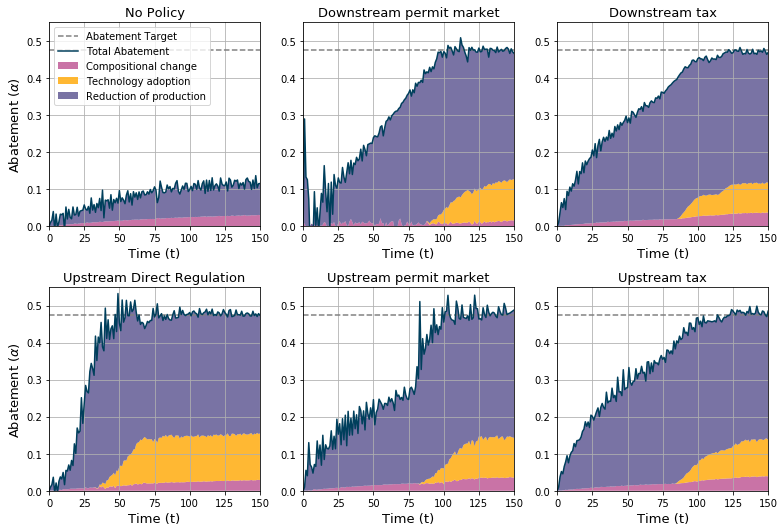

In [80]:
# Abatement Decomposition 
            
def plot_abatement_analysis(results, mode = ""):

    sec,p,usec,X=results[0]
    if mode == "lim_cov": 
        print("test")
        sec,p,usec = X
    t0= p.t_start-1 
    T = p.T 
    
    fig, ([[ax0,ax2,ax1],[ax3,ax5,ax4]]) = plt.subplots(nrows=2, ncols=3, figsize=(11, 7.5))
    axs = [ax0,ax1,ax2,ax3,ax4,ax5]
    ax0.set_ylabel("Abatement ($α$)", fontsize = fs) 
    ax3.set_ylabel("Abatement ($α$)", fontsize = fs) 
    
    i=0
    for sc in results:
        if True:
            
            sec,p,usec,X=sc
            if mode == "lim_cov": sec,p,usec = X
            axs[i].set_title(p.label, fontsize = fs)
            
            ab_21, ab_1,ab_22,ab_tot = calc_abatement_analysis(sc,t0,mode=mode)
        
            pal = ["#bc5090","#ffa600", "#58508d", "#003f5c"] 
            stacks = axs[i].stackplot(range(151), ab_21, ab_1,ab_22,  labels=["Compositional change","Technology adoption","Reduction of production"], alpha=0.8, colors=pal) # range(t0,p.T)
            axs[i].axhline(sec.E[t0]-p.E_max,color='grey',ls='--',label='Abatement Target') # Abatement Target Line
            axs[i].plot(range(151),ab_tot,label="Total Abatement")
            axs[i].set_xlabel('Time (t)', fontsize = fs)
            axs[i].grid()
            axs[i].set_xlim([0,150])
            axs[i].set_ylim([0,0.55])
            
        i+=1

    ax0.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig('Outputs/abatement.pdf')

if analyze_single_run == True:
    plot_abatement_analysis(results)   

In [81]:
def plot_permit_market_dynamics(results):
    
    
    fig, ([ax1, ax3],[ax2, ax4]) = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

    sec,p = results[1]
    l1, = ax1.plot(range(p.T),[p.reg.pf[t] for t in range(p.T)], label='Grandfathering (Uniform)', color='C1')  
    
    sec,p = results3[1]
    l2, = ax1.plot(range(p.T),[p.reg.pf[t] for t in range(p.T)], label='Grandfathering (Discriminatory)', color='C1', linestyle='--') 
    
    sec,p = results[2]
    l3, = ax1.plot(range(p.T),[p.reg.pf[t] for t in range(p.T)], label='Auction (Uniform)', color='C2')         
    
    sec,p = results3[2]
    l4, = ax1.plot(range(p.T),[p.reg.pf[t] for t in range(p.T)], label='Auction (Discriminatory)', color='C2', linestyle='--')      
        
    sec,p = results[3]
    l5, = ax1.plot(range(p.T),[p.reg.pf[t] for t in range(p.T)], label='Tax', color='C3')    
            
    # Technological Optimistic Setting

    sec,p = results2[1]
    ax3.plot(range(p.T),[p.reg.pf[t] for t in range(p.T)], label='Grandfathering (TO)', color='C1') 
    
    sec,p = results2[2]
    ax3.plot(range(p.T),[p.reg.pf[t] for t in range(p.T)], label='Auction (TO)', color='C2')     

    sec,p = results2[3]
    ax3.plot(range(p.T),[p.reg.pf[t] for t in range(p.T)], label='Tax (TO)', color='C3')
    
    ax1.set_ylabel('Permit market price / Tax level', fontsize = fs)

    i=0
    for sc in results: 
        sec,p,usec,X = sc   
        ax2.plot(range(p.T),[p.f_ex.u_t[t] for t in range(p.T)], label=p.mode, color='C'+str(i))
        i+=1
        
    sec,p = results2[1]
    ax4.plot(range(p.T),[p.p_ex.u_t[t] for t in range(p.T)], label='Grandfathering (TO)', color='C1') 
    
    sec,p = results2[2]
    ax4.plot(range(p.T),[p.p_ex.u_t[t] for t in range(p.T)], label='Auction (TO)', color='C2')     
    
    sec,p = results3[1]
    ax2.plot(range(p.T),[p.p_ex.u_t[t] for t in range(p.T)], label='Grandfathering (Discriminatory)', color='C1', linestyle='--')  
    
    sec,p = results3[2]
    ax2.plot(range(p.T),[p.p_ex.u_t[t] for t in range(p.T)], label='Auction (Discriminatory)', color='C2', linestyle='--')  
            
        
    ax2.set_xlabel('Time (t)', fontsize = fs)
    ax4.set_xlabel('Time (t)', fontsize = fs)
    ax2.set_ylabel('Permit trading volume', fontsize = fs)
    
    ax1.set_title("Average parameters", fontsize = fs)
    ax3.set_title("Technologically optimistic parameters", fontsize = fs)
    
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax4.grid()
    
    fig.subplots_adjust(bottom=0.14, hspace=0.1,wspace=0.1)
    handles, labels = ax1.get_legend_handles_labels()
    #fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=fs) 
    plt.savefig('Outputs/permits.pdf')
    
if analyze_single_run == True and False:
    plot_permit_market_dynamics(results)

In [82]:
def plot_market_share(ax,sec,p):
    
    x = np.linspace(0, 1, 10)
    number = p.Np
    cmap = plt.get_cmap('nipy_spectral')
    colors = [cmap(i) for i in np.linspace(0, 1, number)]
    
    end = p.T
    ts = range(1,end)
    for i, color in enumerate(colors):
        ax.plot(ts,[sec[i].s[t] for t in ts], label=f'Producer {sec[i].j}, α = {sec[i].α}', color=color)
    ax.set_xlabel('Time (t)', fontsize = fs)
    ax.set_xticks(np.arange(1,end, 1),minor = True)
    ax.grid()

def plot_market_shares(results):
    
    fig, ([[ax0,ax1], [ax2, ax3]]) = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
    axs = [ax0,ax1,ax2,ax3]
    
    i=0
    
    for sc in results:
        if True: #i>0:
            sec,p,usec,X = sc
            plot_market_share(axs[i],sec,p)
            axs[i].set_ylim((0,0.15))
            ax0.set_ylabel("Market Share", fontsize = fs)
            ax2.set_ylabel("Market Share", fontsize = fs)
            axs[i].set_title(p.label)
        i+=1
    #ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    plt.savefig('Outputs/market-shares.pdf')

if False: #analyze_single_run == True:
    plot_market_shares(results)

In [83]:
# Abatement Cost Curve - Example

def generate_λ(A0,α,p):     
    λ =[] 
    for i in range(p.λ_n):
        a=(A0*p.λ_max)/p.λ_n 
        MAC=a*α*(i+1) 
        b=a*MAC
        λ.append([a,b])
    return λ      

if False: #analyze_single_run:
    sec,p,usec,X=results[0]
    ab0 = generate_λ(1,5.5,p)

    arr = np.array([ [a[1]/a[0] for a in ab0] , [a[0] for a in ab0] ])
    plt.title("Abatement cost curve")
    data = arr[:,arr[0,:].argsort()]

    cumsum = np.cumsum([0]+list(data[1]))
    pos = cumsum[:-1]

    plt.bar(pos, data[0], data[1], align='edge', linewidth=1,edgecolor='black', alpha=0.5)

    plt.xlabel('Reduction of emissions per produced good (a)', fontsize=fs)
    plt.ylabel('Marginal costs per reduced emission (b/a)')
    plt.grid()
    plt.savefig('Outputs/mac2.pdf')
    plt.show()
    

In [84]:
## Detailled Analysis ##

def fplot(variable,label,mode,ax,sec):
    
    start = 1
    end = p.T
    ts = range(start,end) 

    if mode == "ind":
        for i in range(p.Np):
            exec("ax.plot(ts,[sec["+str(i)+"]."+variable+"[t] for t in ts], label=f'Producer {sec["+str(i)+"].j}')") 
    if mode == "ind_up":
        for i in range(p.Nf):
            exec("ax.plot(ts,[usec["+str(i)+"]."+variable+"[t] for t in ts], label=f'Producer {usec["+str(i)+"].j}')") 
    if mode == "sum":
        exec("ax.plot(ts,[sum([j."+variable+"[t] for j in sec1]) for t in ts],'k-')")
    ax.set_xlabel('time (t)')
    ax.set_ylabel(label)
    ax.set_xticks(np.arange(start,end, 1),minor = True)
    ax.grid()

def plot_main_dynamics(sec,usec,p):

    fig, ((ax1, ax2,ax3,ax4), (ax5,ax6,ax7,ax8), (ax9,ax10,ax11,ax12)) = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))

    fplot("qg","Fuel Production (qg f)","ind_up",ax1,sec)
    fplot("pe","Emission price","ind",ax2,sec)
    fplot("pf","Fuel Buying Price","ind",ax3,sec) 
    fplot("qg","Goods Production (qg)","ind",ax4,sec)
    fplot("pg","Fuel Sales Price (pg f)","ind_up",ax5,usec)
    fplot("pe","Emission price","ind_up",ax6,sec)
    fplot("m2","m2","ind_up",ax7,usec)
    fplot("pg","Goods Sales Price","ind",ax8,sec) 
    fplot("s","Supplier Market-share (s f)","ind_up",ax9,usec)
    fplot("q_max","q_max","ind_up",ax10,usec)
    fplot("A","Emission Intensity (A)","ind",ax11,sec)
    fplot("s","Producer Market-share (f)","ind",ax12,sec)

    plt.tight_layout()

if single_run_details == True:
    for i in range(0,len(scenarios)): 
        sec, p , usec, X = results[i]
        #sec, p , usec = X # Looks at limited coverage case
        print("Scenario ",i)
        print(p.label)
        plot_main_dynamics(sec,usec,p)
        plt.show()

In [85]:
def plot_aggregate_vars(sec,usec,p):

    fig, ((ax1, ax2,ax7), (ax3,ax4,ax8), (ax5,ax6,ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

    start = 0
    end = p.T
    ts = range(start,end)

    ax1.plot(ts,[sum([j.qg[t] for j in usec]) for t in ts],label="Fuel Production")
    ax1.plot(ts,[usec.D[t] for t in ts],"--",label="Fuel Demand")     
    ax1.set_xlabel('time (t)')
    ax1.set_ylabel('Demand and Supply')
    ax1.set_xticks(np.arange(start,end, 1),minor = True)
    ax1.legend()
    ax1.grid()

    ax2.plot(ts,[sum([j.qg[t] for j in sec]) for t in ts],label="Goods Production")
    ax2.plot(ts,[sec.D[t] for t in ts],"--",label="Goods Demand")     
    ax2.set_xlabel('time (t)')
    ax2.set_ylabel('Demand and Supply')
    ax2.set_xticks(np.arange(start,end, 1),minor = True)
    ax2.legend()
    ax2.grid()

    ax3.plot(ts,[usec.p[t] for t in ts],label="Fuel Price")   
    ax3.set_xlabel('time (t)')
    ax3.set_ylabel('Prices')
    ax3.set_xticks(np.arange(start,end, 1),minor = True)
    ax3.legend()
    ax3.grid()

    ax4.plot(ts,[sec.p[t] for t in ts],label="Goods Price")     
    ax4.set_xlabel('time (t)')
    ax4.set_ylabel('Prices')
    ax4.set_xticks(np.arange(start,end, 1),minor = True)
    ax4.legend()
    ax4.grid()
   
    ax5.plot(ts,[p.d_sec.E[t] for t in ts],label="Fuel use / Emissions")  
    ax5.set_xlabel('time (t)')
    ax5.set_ylabel('Fuel use / Emissions')
    ax5.set_xticks(np.arange(start,end, 1),minor = True)
    ax5.legend()
    ax5.grid()
    
    ax6.plot(ts,[p.f_ex.f_t[t] for t in ts],label="Fuel trading quantity")     
    ax6.set_xlabel('time (t)')
    ax6.set_ylabel('Trading quantity')
    ax6.set_xticks(np.arange(start,end, 1),minor = True)
    ax6.legend()
    ax6.grid() 

    ax7.plot(ts,[p.p_ex.uA[t] for t in ts],label="Permit Supply")
    ax7.plot(ts,[p.p_ex.uB[t] for t in ts],"--",label="Permit Demand")     
    ax7.set_xlabel('time (t)')
    ax7.set_ylabel('Demand and Supply')
    ax7.set_xticks(np.arange(start,end, 1),minor = True)
    ax7.legend()
    ax7.grid()

    ax8.plot(ts,[p.p_ex.pe[t] for t in ts],label="Permit Price")   
    ax8.set_xlabel('time (t)')
    ax8.set_ylabel('Prices')
    ax8.set_xticks(np.arange(start,end, 1),minor = True)
    ax8.legend()
    ax8.grid()
    
    ax9.plot(ts,[p.reg.qp[t] for t in ts],label="Succesfull bids")  
    ax9.set_xlabel('time (t)')
    ax9.set_ylabel('Trading quantity')
    ax9.set_xticks(np.arange(start,end, 1),minor = True)
    ax9.legend()
    ax9.grid()     
           
    plt.tight_layout()

if False: #single_run_details == True:
    for i in range(0,len(scenarios)):
        sec, p , usec, X = results[i]
        print("Scenario ",i)
        print(p.label)
        plot_aggregate_vars(sec,usec,p)
        plt.show()

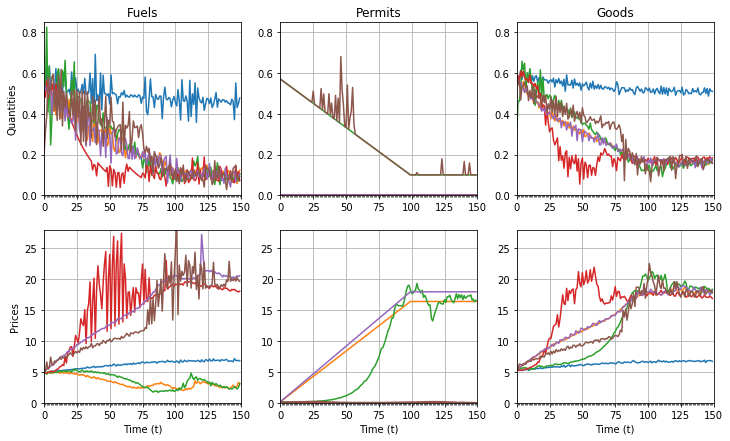

In [86]:
def plot_aggregate_vars(results):

    fig, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(12, 7))
    
    sec, p , usec , X = results[0]
    start = 50
    end = p.T
    ts = range(start,end)
    colors = ["C0","C1","C2","C3","C4","C5"]
    
    for i,sc in enumerate(results):
        
        sec, p , usec , X = sc     

        ax1.plot(range(150),[sum([j.qg[t] for j in usec]) for t in ts],colors[i],label="Fuel Production") 
        
        ax2.plot(range(150),[p.p_ex.uA[t] for t in ts],colors[i],label="Permit Supply")
        
        ax3.plot(range(150),[sum([j.qg[t] for j in sec]) for t in ts],colors[i],label="Goods Production")   
        
        ax4.plot(range(150),[usec.p[t] for t in ts],colors[i],label="Fuel Price")  
        
        ax5.plot(range(150),[p.reg.pe[t] for t in ts],colors[i],label="Permit Price")
        
        ax6.plot(range(150),[sec.p[t] for t in ts],colors[i],label="Goods Price")   
    
    ax1.set_title('Fuels')
    ax2.set_title('Permits')
    ax3.set_title('Goods')
    
    ax1.set_ylabel('Quantities')
    ax4.set_ylabel('Prices')
    
    #ax1.set_xlabel('time (t)')
    for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
        ax.set_xticks(range(150),minor = True)
        ax.set_xlim([0,150])
        ax.grid()
        ax.set_ylim(bottom=0)
        
        if ax in [ax1,ax2,ax3]: ax.set_ylim([0,0.85])
        else: ax.set_ylim([0,28])

    ax4.set_xlabel('Time (t)')
    ax5.set_xlabel('Time (t)')
    ax6.set_xlabel('Time (t)')

    
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color="C0", lw=2),
                    Line2D([0], [0], color="C1", lw=2),
                    Line2D([0], [0], color="C2", lw=2),
                    Line2D([0], [0], color="C3", lw=2),
                    Line2D([0], [0], color="C4", lw=2),
                    Line2D([0], [0], color="C5", lw=2)]

if analyze_single_run:
    plot_aggregate_vars(results)
    plt.show()

In [87]:
## Plot Tables of Variables over Time ##

def plot_tables(sec,p,start,end):

    for j in range(3):
        f = sec[j]
        m = [["A"]+list(f.A),["MAC"]+list(f.MAC),["q_max"]+list(f.q_max),["qg_d"]+list(f.qg_d),["qg"]+list(f.qg),["pf"]+list(f.pf),["qp_d"]+list(f.qp_d),["u_t"]+list(f.u_t),["u_i"]+list(f.u_i),["pg"]+list(f.pg),["pe"]+list(f.pe),["m"]+list(f.m),["m2"]+list(f.m2)]
        m2 = [[i[0]]+i[start+1:end] for i in m]
        headers =  ["FIRM "+str(j)]+list(range(start,end))
        table = tabulate(m2, headers, floatfmt=".6f")
        print(table)
        print("\n")    

if False: #single_run_details == True:
    sec,p,usec,X = results[2] # Choose Scenario
    start,end = [150,160] # Choose table time-span
    plot_tables(sec,p,start,end) # Choose sec or usec